In [1]:
import scanpy as sc
from torch.utils.data import Dataset, DataLoader
import torch
from flecs.utils import set_seed
from tqdm import tqdm
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import os
from flecs.utils import get_project_root
from flecs.sc.model import ProteinLevelPop, GRNCellPop
from flecs.sc.utils import get_cell_indices

scv.set_figure_params('scvelo')  # for beautified visualization
plt.rcParams["figure.figsize"] = (16,8)

## Load data

In [2]:
set_seed(0)
adata = sc.read_h5ad(os.path.join(get_project_root(),
                                  "datasets", "PerturbSeq", "processed", "adata_processed_with_obs_pseudotime_paths.h5ad")
                     )

In [3]:
sparsity_rand_edges = 0.1
adj_mat = adata.varp["grn_adj_mat"]

adj_mat = adj_mat + np.random.choice([0, 1], size=adj_mat.shape, p=[1.-sparsity_rand_edges, sparsity_rand_edges])

print("edge density", adj_mat.sum() / (4000*4000))
adata.varp["grn_adj_mat"] = adj_mat

edge density 0.111064875


In [4]:
len(adata)

16835

In [5]:
adata

AnnData object with n_obs × n_vars = 16835 × 4000
    obs: 'cell_barcode', 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'n_counts_all', 'S_score', 'G2M_score', 'phase', 'dpt_pseudotime', 'pseudotime_quantile', 'n_counts'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'gene_id', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'g1_s_obs_shortest_paths', 'g2_g1_obs_shortest_paths', 'gene_colors', 'hvg', 'iroot', 'log1p', 'neighbors', 'pca', 'phase_colors', 's_g2_obs_shortest_paths', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
    varp: 'grn_adj_mat'

In [6]:
# def get_cell_phase_indices(_adata):
#     # Get the indices of cells for the different populations
#     g1_cells = list(_adata.obs[_adata.obs["phase"] == 'G1'].index)
#     g2_cells = list(_adata.obs[_adata.obs["phase"] == 'G2M'].index)
#     s_cells = list(_adata.obs[_adata.obs["phase"] == 'S'].index)

#     return g1_cells, g2_cells, s_cells

In [7]:
# # Get cell indices coming from the different batches
# g1_cells, g2_cells, s_cells = get_cell_phase_indices(adata)
# g1_s_adata = adata[g1_cells + s_cells]

## Model

In [8]:
for i in range(1, 100):
    if adata.shape[0] % i == 0:
        print(i)

1
5
7
13
35
37
65
91


In [9]:
batch_size = adata.shape[0] // 35

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
mycellpop = GRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=0, use_2nd_order_interactions=False).to(device)
# mycellpop = ProteinLevelPop(adata=adata, batch_size=batch_size, n_latent_var=50, use_2nd_order_interactions=True)

## Load weights

In [12]:
# Load trained weights
# trained_state_dict = torch.load(os.path.join(get_project_root(), "logs", "trained_mycellpop_dec_29_2.pt"), 
#                                 map_location=torch.device('cpu'))

trained_state_dict = torch.load(os.path.join(get_project_root(), "logs", "trained_mycellpop_jan_02_3.pt"))

In [13]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
# mycellpop["gene"].translation.data = trained_state_dict["translation"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

## Plotting

In [14]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
highly_var_gene_list = list(adata.var.iloc[np.where(adata.X.std(axis=0) > .1)[0]].index)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [15]:
len(highly_var_gene_list)

1214

In [16]:
with torch.no_grad():

    g1_s_velocities = []

    for i in tqdm(range(adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(adata.X[i*batch_size: (i + 1)*batch_size, :, None]).to(device)
#         velocity = mycellpop.get_derivatives(torch.cat((gene_expr,
#                                                         torch.zeros(batch_size, 50, 1)), dim=1))
        velocity = mycellpop.get_derivatives(gene_expr)

#         g1_s_velocities.append(velocity[:, :-50])
        g1_s_velocities.append(velocity)

g1_s_velocities = torch.cat(g1_s_velocities).cpu().numpy()[:, :, 0]
adata.layers["velocity"] = g1_s_velocities
adata.layers["X"] = adata.X

100%|██████████| 35/35 [00:46<00:00,  1.32s/it]


In [17]:
# with torch.no_grad():

#     g1_s_velocities = []

#     for i in tqdm(range(adata.shape[0] // batch_size)):
#         gene_expr = torch.Tensor(adata.X[i*batch_size: (i + 1)*batch_size, :, None])
#         velocity = mycellpop.get_derivatives(torch.cat((gene_expr,
#                                                         torch.zeros(batch_size, 50, 1)), dim=1))

#         g1_s_velocities.append(velocity[:, :-50])

# g1_s_velocities = torch.cat(g1_s_velocities).cpu().numpy()[:, :, 0]
# adata.layers["velocity"] = g1_s_velocities
# adata.layers["X"] = adata.X

In [18]:
# with torch.no_grad():
    
#     g1_s_velocities = []
    
#     for i in tqdm(range(adata.shape[0] // batch_size)):
#         gene_expr = torch.Tensor(adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        
#         gene_expr = torch.cat((gene_expr, gene_expr), dim=2)
#         velocity = mycellpop.get_derivatives(gene_expr)
        
#         g1_s_velocities.append(velocity)

# g1_s_velocities = torch.cat(g1_s_velocities).cpu().numpy()[:, :, 0]
# adata.layers["velocity"] = g1_s_velocities
# adata.layers["X"] = adata.X

In [19]:
# with torch.no_grad():

#     g1_s_velocities = []

#     for i in tqdm(range(adata.shape[0] // batch_size)):
#         gene_expr = torch.Tensor(adata.X[i*batch_size: (i + 1)*batch_size, :, None])

#         gene_expr = torch.cat((gene_expr, gene_expr), dim=2)
#         velocity = mycellpop.get_derivatives(torch.cat((gene_expr,
#                                                         torch.zeros(batch_size, 200, 2)), dim=1))

#         g1_s_velocities.append(velocity[:, :-200])

# g1_s_velocities = torch.cat(g1_s_velocities).cpu().numpy()[:, :, 0]
# adata.layers["velocity"] = g1_s_velocities
# adata.layers["X"] = adata.X

In [20]:
scv.tl.velocity_graph(adata, xkey="X", gene_subset=highly_var_gene_list, n_jobs=8)

computing velocity graph (using 8/40 cores)


  0%|          | 0/16835 [00:00<?, ?cells/s]

    finished (0:00:47) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding


    finished (0:00:06) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


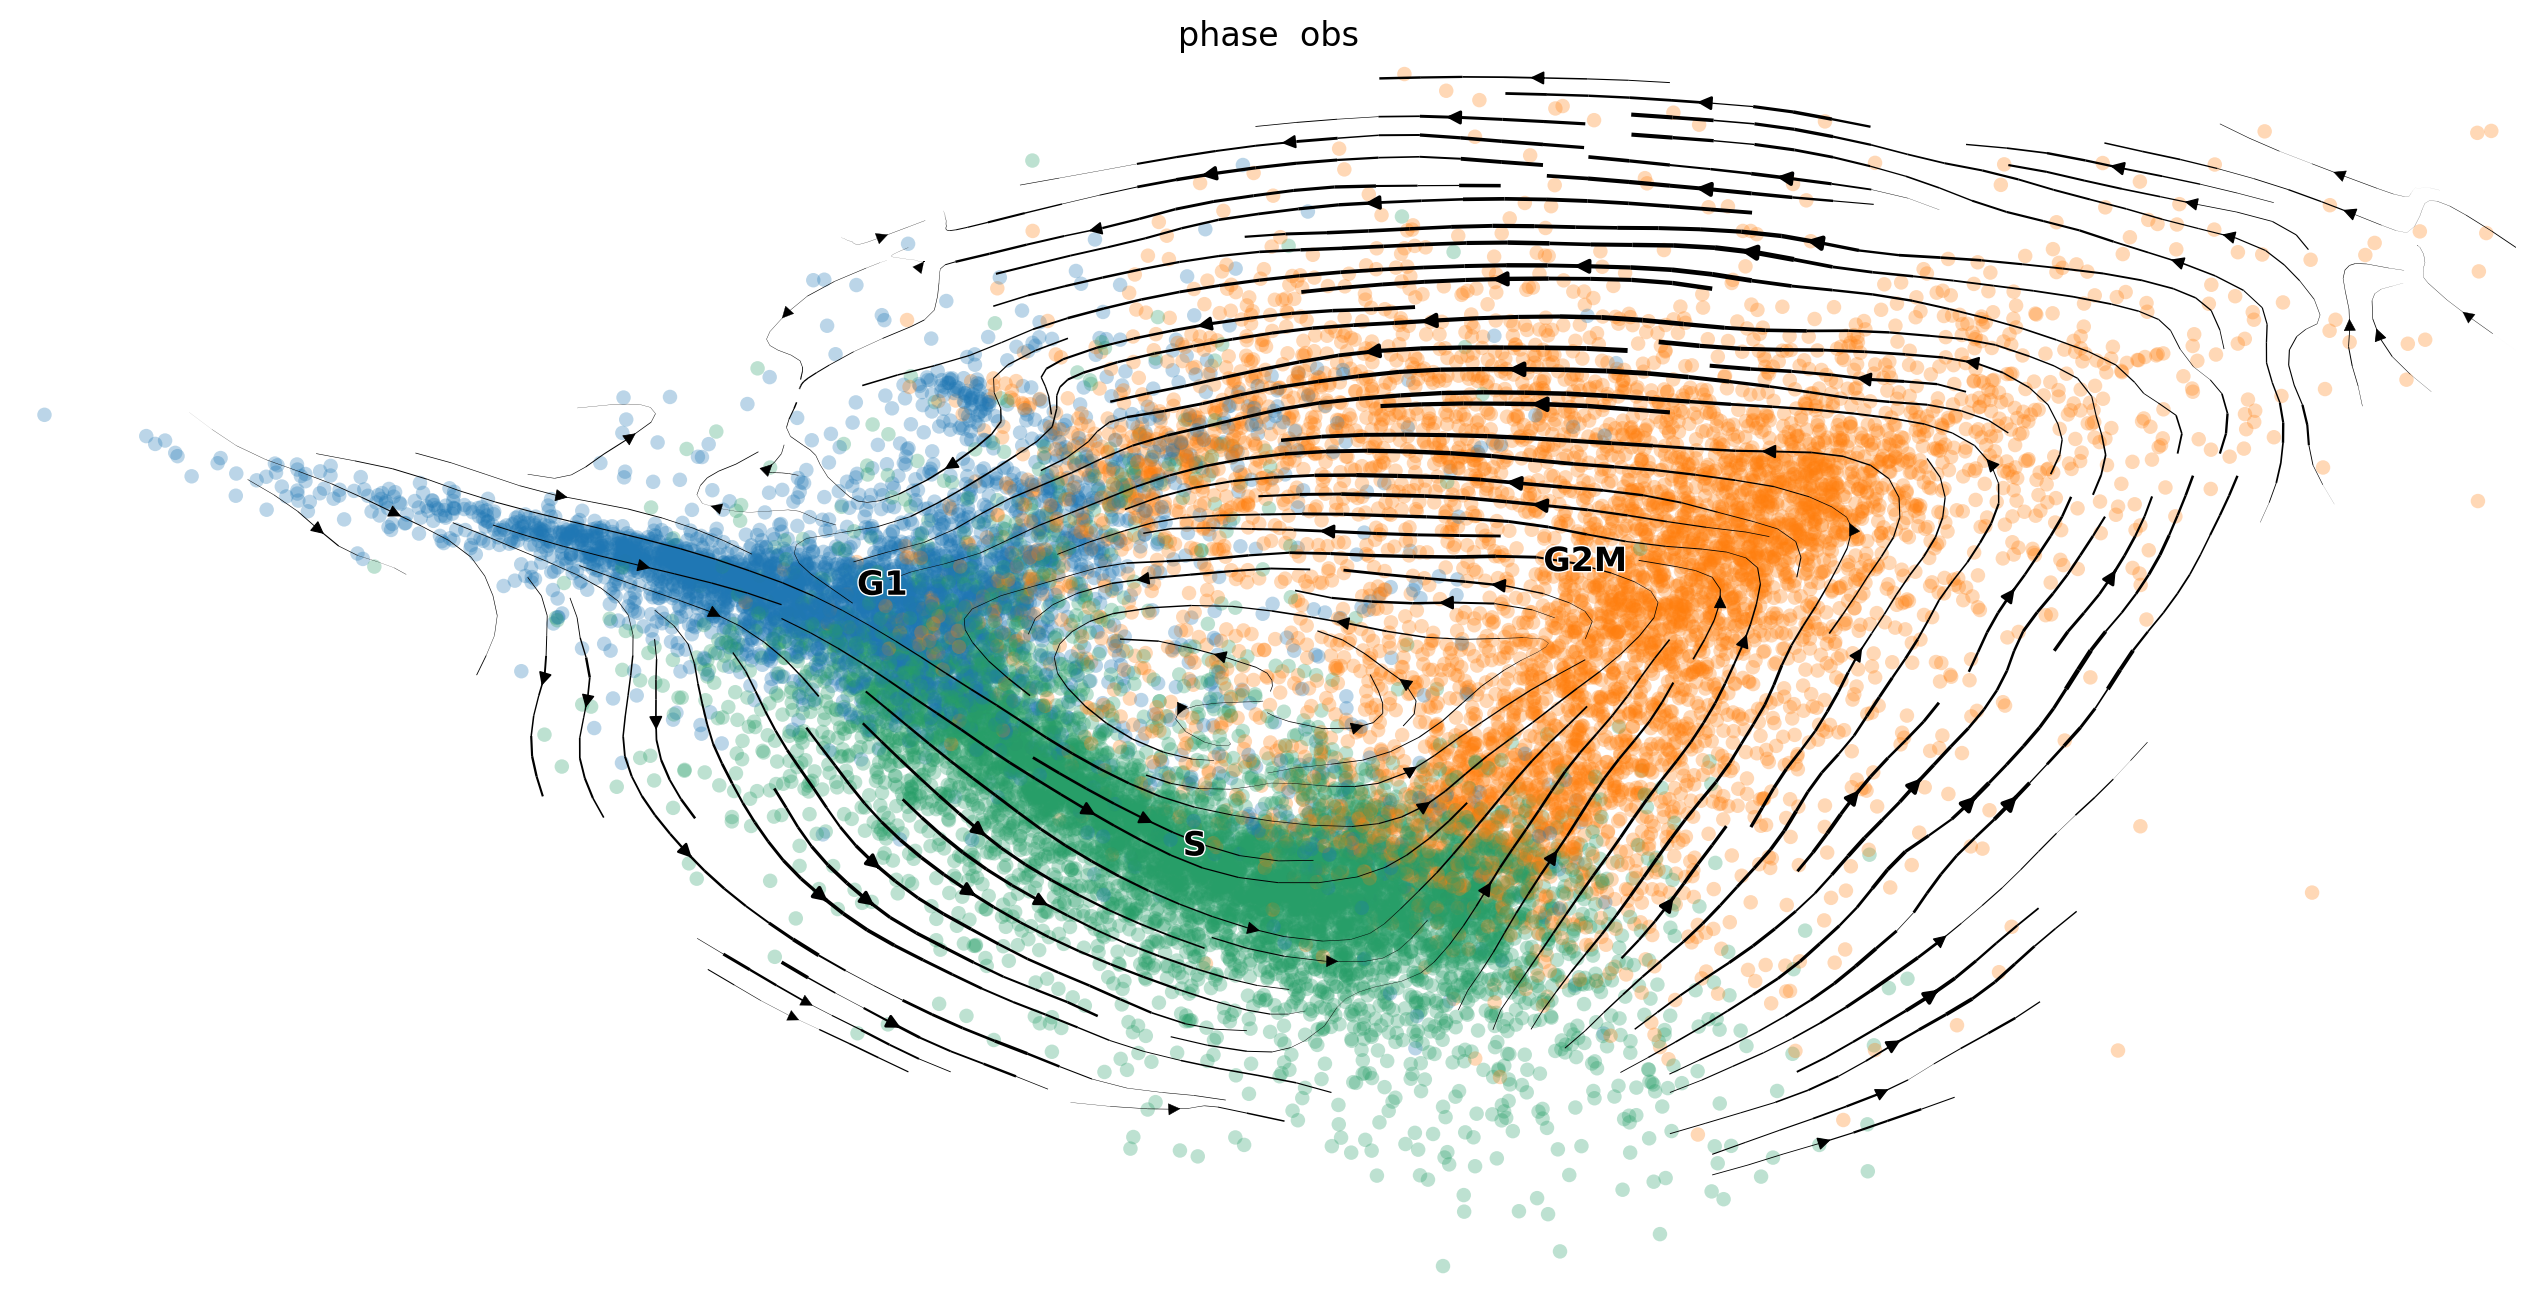

In [21]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color="phase", layer="obs")

In [ ]:
# cmp_unsorted_adata.write_h5ad("cmp_unsorted_with_latent_prot.h5ad")